# 2. Analyze PDBs from RCSB  

This tutorial demonstrates how to use FragBEST-Myo for analyzing a protein ensemble (multiple PDBs) and ranking those protein structures using `HoloDescriptor` and `HoloDescriptorAnalyser`.  

A common starting point for analyzing protein structures is retrieving PDB files from [RCSB](https://www.rcsb.org/). Here, we show how to fetch PDB files from RCSB and preprocess them before using FragBEST-Myo. Predictions for each file are then used to generate "holo descriptors" (a set of characteristics describing the similarity to the holo conformation) with `HoloDescriptor`. Finally, the holo-descriptor files from different structures are combined and ranked using `HoloDescriptorAnalyser`.  

### In this tutorial, you will learn:  
- How to fetch and preprocess PDB files from RCSB for FragBEST-Myo.  
- How to make predictions easily with the pretrained FragBEST-Myo.  
- How to use `HoloDescriptor` and `HoloDescriptorAnalyser` to compare and rank protein structures (conformations).

## Set up the path and import required packages

In [1]:
# only for once to append the root of the project
import os
import sys
import warnings


def find_project_root(marker=".git"):
    current_path = os.getcwd()
    while current_path != os.path.dirname(current_path):  # Stop at the filesystem root
        if marker in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None  # Return None if the marker is not found


project_root = find_project_root()
print(project_root)
# should be at the root of the project
# e.g., /.../.../.../FragBEST-Myo

# Add project_root to the Python path
sys.path.append(project_root)

# ignore warnings
warnings.filterwarnings("ignore")

/home/yuyang/Project_local/FragBEST-Myo


In [2]:
# import required libraries
import matplotlib.pyplot as plt
from IPython.display import HTML, Image, display

from utils.datasets.general import read_model
from utils.datasets.traj_handler import TrajectoryHandler
from utils.ppseg.holo_descriptor.holo_descriptor import (
    HoloDescriptor,
    HoloDescriptorAnalyser,
)


def display_df_html(df):
    """
    Display a pandas DataFrame as HTML in Jupyter Notebook.
    """
    for each in df:
        # check if the column is a list
        if isinstance(df[each].iloc[0], list):
            # convert the list to a string
            # (use two decimal places and format it as a string)
            df[each] = df[each].apply(
                lambda x: "[" + ",".join([f"{i:.2f}" for i in x]) + "]"
            )
    display(HTML('<div style="overflow-x: auto">' + df.to_html() + "</div>"))

```{attention}
It is recommended to always use absolute paths.
```

## Download and Preprocess the PDBs from RCSB  

This section showcases the extended application of FragBEST-Myo using PDBs of not only the Cardiac Myosin (CM)-Omecamtiv Mecarbil (OM) complex but also mavacamten-bound CM, apo CM, and apo skeletal myosin. For more structural details and a comparison of the OM/Mava pocket, refer to the [reference](https://doi.org/10.1038/s41467-024-47587-9).  

### PDBs Overview  

*Cardiac Myosin (CM):*  
- **Omecamtiv Mecarbil (OM)-bound form:**  
  - [**5N69**](https://www.rcsb.org/structure/5n69) (whole S1 fragment, pre-powerstroke (PPS) state, Organism: cattle)  
  - [**8QYU**](https://www.rcsb.org/structure/8qyu) (whole S1 fragment, PPS state, Organism: cattle)  
- **Mavacamten (Mava)-bound form:**  
  - [**8QYQ**](https://www.rcsb.org/structure/8qyq) (whole S1 fragment, PPS state, Organism: cattle)  
  - [**8QYR**](https://www.rcsb.org/structure/8qyr) (motor domain, PPS state, Organism: cattle)  
- **Apo form (empty OM/Mava pocket):**  
  - [**8QYP**](https://www.rcsb.org/structure/8qyp) (motor domain, PPS state, Organism: cattle)  

*Skeletal Myosin (SM):*  
- **Apo form:**  
  - [**6YSY**](https://www.rcsb.org/structure/6ysy) (PPS state, Organism: European rabbit)  

---

### General Protocols (Download & Preprocess)  

1. **Download the PDBs from RCSB.**  
2. **Extract the biological unit.**  
3. **Add hydrogens to the structures**: to create a solvent-excluded surface, adding the hydrogens is required.   
4. **Superimpose the structures**: For convenience, it is easier to analyze the data and extract the region of interest.     

Steps 1–3 can be performed using different tools or methods. This tutorial focuses on step 4 (superimposing the structures).  

---

### Preprocessed Files (step 1-3) 

We have prepared the files with biological units by selecting specific chains and adding hydrogens using `reduce`. For details, see [here](./supplementary/02a_preprocess_PDBs.ipynb). Download the files from [Zenodo](https://zenodo.org/records/17779759) to your local `FragBEST-Myo/dataset/examples`. 

**Chains and Ligands:**  
- **5N69 (cattle CM-OM):** chain B, G (OM ligand name: 2OW)  
- **8QYU (cattle CM-OM):** chain B, G (OM ligand name: 2OW)  
- **8QYQ (cattle CM-Mava):** chain B, D (Mava ligand name: XB2)  
- **8QYR (cattle CM-Mava):** chain B (Mava ligand name: XB2)  
- **8QYP (cattle CM):** chain A (no ligand at OM/Mava pocket)  
- **6YSY (rabbit SM):** chain A, B (no ligand at OM/Mava pocket)  

**File Format:** we saved the prepared files are saved with the extension `.biounit_addHs.pdb`.   

In [3]:
# ----------------- Start of user-defined variables -----------------
investigation_list = ["8QYP", "8QYQ", "8QYR", "8QYU", "6YSY", "5N69"]
examples_dir = f"{project_root}/dataset/examples"

output_dir = f"{project_root}/dataset/examples/outputs_RCSB_pdb"
# ----------------- End of user-defined variables -------------------

# annotation for the investigation list
annotation_dict = {
    "5N69": "5N69: cattle's CM-OM (holo)",
    "8QYU": "8QYU: cattle's CM-OM (holo)",
    "8QYQ": "8QYQ: cattle's CM-Mava (holo)",
    "8QYR": "8QYR: cattle's CM-Mava (holo)",
    "8QYP": "8QYP: cattle's CM (apo)",
    "6YSY": "6YSY: rabbit's SM (apo)",
}

# create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Download the prepared pdb files from zenodo
!wget -O f"{examples_dir}/5N69.biounit_addHs.pdb" \
    https://zenodo.org/records/18630776/files/5N69.biounit_addHs.pdb

!wget -O f"{examples_dir}/6YSY.biounit_addHs.pdb" \
    https://zenodo.org/records/18630776/files/6YSY.biounit_addHs.pdb

!wget -O f"{examples_dir}/8QYP.biounit_addHs.pdb" \
    https://zenodo.org/records/18630776/files/8QYP.biounit_addHs.pdb

!wget -O f"{examples_dir}/8QYQ.biounit_addHs.pdb" \
    https://zenodo.org/records/18630776/files/8QYQ.biounit_addHs.pdb

!wget -O f"{examples_dir}/8QYR.biounit_addHs.pdb" \
    https://zenodo.org/records/18630776/files/8QYR.biounit_addHs.pdb

!wget -O f"{examples_dir}/8QYU.biounit_addHs.pdb" \
    https://zenodo.org/records/18630776/files/8QYU.biounit_addHs.pdb

### Superimpose the Structures (step 4)  

To facilitate easier comparison of the structures, **superimposing them in advance is strongly recommended.** This ensures that the pocket center selection remains consistent across all structures, and both the proteins (PDB files) and their surface files (PLY files) can be visualized in PyMOL without requiring additional alignment or superimposition.  

We used a third-party structure alignment script with minor modifications for this purpose. Download it from [here](https://gist.github.com/yuyuan871111/7213979038ed5d6a71a54cedbd5577e1) and put `alignment_structure.py` into `utils/thirdparty/`. The usage of the script is provided below:  

```bash
python utils/thirdparty/alignment_structure.py \
    [reference PDB file path] [mobile PDB file path] \
    --r_chain [name of chain in reference] --m_chain [name of chain in mobile] \
    [--verbose]
# --verbose: Displays detailed messages during the superimposition process (including warnings).
```  

All structures were superimposed onto the reference structure `PPS_OMB_min_cg_pl.pdb`, specifically chain `X`, which serves as the reference for training trajectories. The corresponding chain for each PDB file was carefully selected as follows:  
- **5N69:** chain B  
- **8QYU:** chain B  
- **8QYQ:** chain B  
- **8QYR:** chain B  
- **8QYP:** chain A  
- **6YSY:** chain A

In [4]:
# structure alignment
!python {project_root}/utils/thirdparty/alignment_structure.py \
    {project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb \
    {project_root}/dataset/examples/5N69.biounit_addHs.pdb \
    --r_chain X --m_chain B

!python {project_root}/utils/thirdparty/alignment_structure.py \
    {project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb \
    {project_root}/dataset/examples/8QYU.biounit_addHs.pdb \
    --r_chain X --m_chain B

!python {project_root}/utils/thirdparty/alignment_structure.py \
    {project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb \
    {project_root}/dataset/examples/8QYQ.biounit_addHs.pdb \
    --r_chain X --m_chain B

!python {project_root}/utils/thirdparty/alignment_structure.py \
    {project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb \
    {project_root}/dataset/examples/8QYR.biounit_addHs.pdb \
    --r_chain X --m_chain B

!python {project_root}/utils/thirdparty/alignment_structure.py \
    {project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb \
    {project_root}/dataset/examples/8QYP.biounit_addHs.pdb \
    --r_chain X --m_chain A

!python {project_root}/utils/thirdparty/alignment_structure.py \
    {project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb \
    {project_root}/dataset/examples/6YSY.biounit_addHs.pdb \
    --r_chain X --m_chain A

RMSD between structures: 0.40
RMSD between structures: 0.73
RMSD between structures: 1.75
RMSD between structures: 1.03
RMSD between structures: 1.33
RMSD between structures: 2.12


## Make Predictions with FragBEST-Myo

FragBEST-Myo is a specialized version of FragBEST (**Frag**ment-**B**ased protein **E**nsemble semantic **S**egmentation **T**ool) designed specifically for analyzing myosin. The predefined fragments used in this process are illustrated in the figure below.

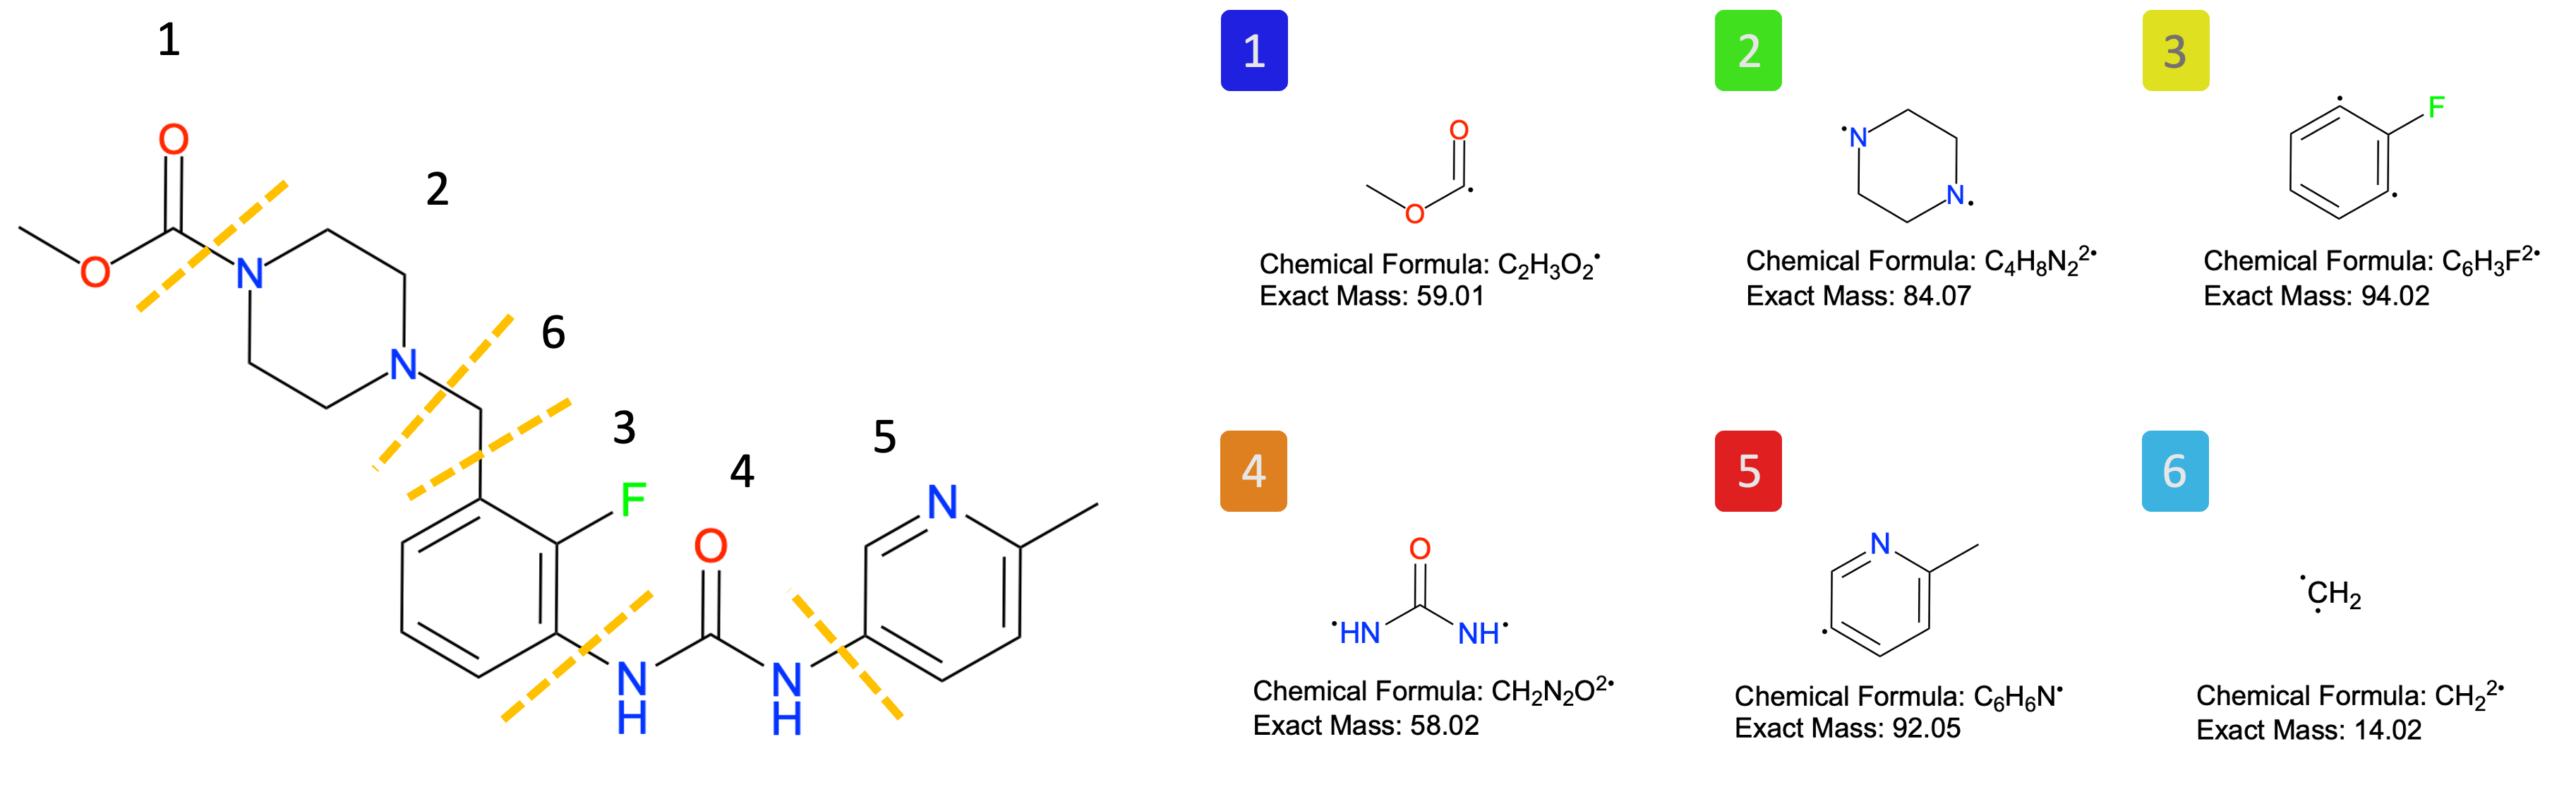

In [5]:
# this is just for visualization
Image(filename=f"{project_root}/imgs/OM_fragment.png")

> As in [Tutorial 1](./01_trajectory_handler.ipynb), we use `TrajectoryHandler` to perform several key tasks: selecting the pocket center (region of interest), generating the protein surface and its features, and making predictions with the pretrained FragBEST-Myo model.

### Step 1: Selecting the Pocket Center  
The pocket center represents the region of interest. Since all structures are aligned to the reference structure (`PPS_OMB_min_cg_pl.pdb`), we use the ligand from this reference structure to determine the pocket center.

To retrieve the pocket center, simply use the function `TrajectoryHandler.get_pocket_center()`.

In [6]:
# ----------------- Start of user-defined variables -----------------
ref_path = f"{project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb"
ligand_name = "2OW"

output_aux_path = f"{output_dir}/pocket_center.txt"
# ----------------- End of user-defined variables -------------------

# read the reference structure
reference = TrajectoryHandler(
    top_path=ref_path,
    ligand_name=ligand_name,
    warning_check=False,
)

# get the pocket center
reference.get_pocket_center()
print("Pocket center:", reference.pocket_center)

# save the pocket center
reference.write_pocket_aux_file(output_aux_path)

Pocket center: [48.24788948519146, 107.53731136226175, 63.72042723995956]


To read these structures, we use the default radius of interest value.

In [7]:
# ligand names
ligand_names = {
    "5N69": "2OW",
    "8QYQ": "XB2",
    "8QYP": None,
    "8QYR": "XB2",
    "8QYU": "2OW",
    "6YSY": None,
}

# read the H-added aligned structures with ligand names
traj_handlers = {}
for each in investigation_list:
    print(each)
    # read the H-added structures with ligand names
    traj_handlers[each] = TrajectoryHandler(
        top_path=f"{examples_dir}/{each}.biounit_addHs.aligned.pdb",
        ligand_name=ligand_names[each],
    )

8QYP
ligand_name is not provided
8QYQ
XB2 is in the trajectory
8QYR
XB2 is in the trajectory
8QYU
2OW is in the trajectory
6YSY
ligand_name is not provided
5N69
2OW is in the trajectory


Also, we can visualize the region of interest with the structure by adding a sphere with a radius of interest in `nglview`. **Go and check it whether it is at OM/Mava pocket**.    

In [9]:
# Visualization locally (uncomment to import the package)
# import nglview as nv

# ----------------- Start of user-defined variables -----------------
query = "5N69"  # change here to visualize different structure
# (e.g. 8QYP, 8QYQ, 8QYR, 8QYU, 6YSY, 5N69)
# ----------------- End of user-defined variables -------------------

# visualize the structure (uncomment to visualize)
# view = nv.show_mdanalysis(traj_handlers[query].universe)
# view.shape.add(
#     "sphere",
#     list(reference.pocket_center),
#     [0.5, 0.5, 0.5],
#     reference.radius_of_interest,
#     f"region of interest with {reference.radius_of_interest} angstrom radius",
# )  # the region of interest with selected radius and the pocket center
# view

### Step 2: Data preparation from PDB to H5   
Next, we utilize the all-in-one data preparation workflow in `TrajectoryHandler` for each structure.

In [8]:
# takes around 1-2 minutes for each structure (in total, around 10 minutes)
for each in investigation_list:
    print(each)
    pdb_path = f"{output_dir}/{each}_protein.pdb"
    ply_path = f"{output_dir}/{each}_protein.ply"
    h5_path = f"{output_dir}/{each}_protein.h5"

    # suppress the log messages
    traj_handlers[each].warning_check = False

    # define the pocket center for each structure
    traj_handlers[each].pocket_center = reference.pocket_center

    # data preparation workflow
    traj_handlers[each].preprocess_workflow(
        pdb_path=pdb_path, ply_path=ply_path, h5_path=h5_path, with_label=False
    )

8QYP
8QYQ
8QYR
8QYU
6YSY
5N69


### Step 3: Making predictions with the pretrained model
Finally, use the pretrained model for the prediction, which will be added to the PLY files.

In [9]:
# ----------------- Start of user-defined variables -----------------
model_path = f"{project_root}/utils/ppseg/myo/Kfold2_best_model_169_miou=0.7525.pt"
# ----------------- End of user-defined variables -------------------


# Load pretrained model
model = read_model(model_path)

# make prediction for each structure
for each in investigation_list:
    ply_path = f"{output_dir}/{each}_protein.ply"
    h5_path = f"{output_dir}/{each}_protein.h5"

    # make prediction
    traj_handlers[each].add_prediction_to_ply(
        ply_path=ply_path,
        h5_path=h5_path,
        model=model,
    )

    print(each, "done")

8QYP done
8QYQ done
8QYR done
8QYU done
6YSY done
5N69 done


## Holo Descriptors and Their Analysis  

Holo descriptors, a new feature introduced in FragBEST, represent characteristics unique to each conformation (structure) based on model-generated results. These descriptors are closely associated with the similarity to the holo (ligand-bound) conformation. By leveraging multiple holo descriptors through `HoloDescriptorAnalyser`, we can compare different conformations (structures) and identify the most likely candidates for holo-like conformations.  

Holo-like conformations are particularly valuable for structure-based drug design applications, such as ensemble docking and virtual screening, as they are more suitable than apo (ligand-free) conformations.  

### Generate holo descriptor
Now, let's import `HoloDescriptor` and use it to analyze the PLY files.

In [10]:
for each in investigation_list:
    # define the path
    ply_path = f"{output_dir}/{each}_protein.ply"

    # run the holo descriptor
    holo_descriptor = HoloDescriptor(ply_path)
    holo_descriptor.run()
    holo_descriptor.save(f"{output_dir}/{each}_protein.json")  # save the result

    print(each, "done")

8QYP done
8QYQ done
8QYR done
8QYU done
6YSY done
5N69 done


Here is an example of the output json file.

In [11]:
!cat "{output_dir}/{each}_protein.json"

{
  "class_predprobs": [
    0.9984528210784314,
    0.9956434000000002,
    0.9820613559322035,
    0.9997027021276598,
    0.9904739555555556,
    0.9917290784313726,
    0.9998822799999999
  ],
  "overall_predprobs": 0.9966408291630717,
  "class_pt_ratio": [
    0.7040552200172563,
    0.056082830025884385,
    0.05090595340811044,
    0.04055220017256255,
    0.03882657463330457,
    0.08800690250215704,
    0.021570319240724764
  ],
  "nonbck_ratio": 0.2959447799827437,
  "nonbck_class_pt_ratio": 0.04932412999712396,
  "num_of_classes": 7,
  "num_interest_points": 1159,
  "holospace_volume": 1449.4640499945854,
  "holospace_frag_volumes": [
    365.04878959471125,
    149.00407119635796,
    148.27315347231038,
    153.8967073843319,
    567.7775322068007,
    39.189924176341606
  ]
}

### Holo Descriptor Analysis  

The holo descriptors for each conformation (structure) are stored in separate files. `HoloDescriptorAnalyser` is a class designed to combine multiple holo-descriptor files for comprehensive analysis.  

Follow these steps to analyze the holo descriptors:  

1. **Define the Source Directory**  
   Specify the directory where the holo-descriptor files are stored.  

2. **List the Holo-Descriptor Files**  
   Identify and list all `.json` files in the directory that contain holo-descriptor data.  

3. **Combine the Files into a Single DataFrame**  
   Read the holo-descriptor files and merge their contents into a single `pd.DataFrame` for easier analysis.  

4. **Normalize**  
   Apply z-score normalization to selected columns to rescale the chosen descriptors.  
5. **Rank**  
   Rank the conformations based on normalized scores to identify the most probable candidates for holo-like conformations.  

By following these steps, you can effectively analyze and rank conformations for further applications in structure-based drug design.

#### 1. Define the Source Directory  

First, set the source directory where the `.json` files containing holo descriptors are located. 

In [12]:
# source_path having the holo-descriptor json files
hd_analyser = HoloDescriptorAnalyser(source_path=output_dir)

To calculate a volume-based descriptor (D<sub>4</sub>), you need to specify the path to the file containing ligand fragment information, which includes volumes calculated by RDKit. By default, this file is preloaded automatically, so you don't need to specify the path manually. If you would like to prepare your own fragment information file, see [here](./supplementary/fragbest_cheatsheet.md#load-custom-fragment-information-file-to-analyser) for details.

#### 2. List the Files  

Ensure that the `output_dir` contains `.json` files (6 in total for this tutorial). These files are the holo-descriptor files required for the analysis.

In [13]:
# list the files
hd_analyser.list_files()

Found 6 files


#### 3. Read the Files  

Next, read the holo-descriptor files using `HoloDescriptorAnalyser.read()`. This function combines multiple `.json` files into a single `pd.DataFrame`. 

**HoloSpace** is a new concept introduced in FragBEST, representing a putative region capable of accommodating a chemical fragment. Using the FragBEST model, the binding region for a specific fragment is identified and segmented. However, the empty space around the binding region (non-protein overlapping space for ligand atoms) does not always directly correlate with the size of the predicted binding region.  

To address this limitation, the **HoloSpace fragment score (in our paper, referred to as "averaged capped HoloSpace score", also known as D<sub>4</sub>)** was developed. This score evaluates whether the available space is sufficient to accommodate the actual size of the ligand fragment. Please set `holospace_calc=True` to enable its calculation. For more details on the definition of D<sub>4</sub>, refer to our paper. To enable the calculation of the HoloSpace fragment score (D<sub>4</sub>), set the parameter `holospace_calc=True`.

In [14]:
# read the multiple holo descriptor files
df = hd_analyser.read(holospace_calc=True)

display_df_html(df)

,class_predprobs,overall_predprobs,class_pt_ratio,nonbck_ratio,nonbck_class_pt_ratio,num_of_classes,num_interest_points,holospace_volume,holospace_frag_volumes,filename,warnings,holospace_frag_score
0,"[1.00,1.00,0.98,1.00,0.99,0.99,1.00]",0.996641,"[0.70,0.06,0.05,0.04,0.04,0.09,0.02]",0.295945,0.049324,7,1159,1449.464050,"[365.05,149.00,148.27,153.90,567.78,39.19]",5N69_protein.json,,1.0
1,"[1.00,0.94,0.98,0.97,0.99,0.98,0.97]",0.991684,"[0.79,0.02,0.04,0.05,0.04,0.05,0.01]",0.211592,0.035265,7,1087,1139.082320,"[118.38,151.93,374.40,117.30,292.88,55.65]",6YSY_protein.json,,1.0
2,"[0.99,0.96,0.98,0.94,0.95,0.98,0.92]",0.987968,"[0.82,0.02,0.02,0.04,0.05,0.05,0.01]",0.184343,0.030724,7,1188,1850.858793,"[204.46,70.64,628.63,408.35,514.94,13.79]",8QYP_protein.json,,0.894121
3,"[1.00,0.99,1.00,0.99,0.99,0.99,1.00]",0.995404,"[0.74,0.05,0.04,0.04,0.03,0.07,0.02]",0.258418,0.043070,7,1188,1898.602052,"[414.49,335.68,275.12,161.40,680.68,42.05]",8QYQ_protein.json,,1.0
4,"[1.00,0.98,0.97,0.98,0.98,0.99,0.98]",0.992596,"[0.74,0.06,0.04,0.04,0.03,0.06,0.02]",0.257002,0.042834,7,1214,1946.824649,"[482.25,233.52,317.82,147.04,682.45,56.85]",8QYR_protein.json,,1.0
5,"[1.00,0.98,0.99,0.99,0.98,0.99,0.99]",0.994740,"[0.71,0.06,0.05,0.05,0.04,0.07,0.02]",0.294561,0.049093,7,1195,1457.438817,"[312.27,238.16,234.97,126.32,486.58,46.38]",8QYU_protein.json,,1.0


```{note}
All holo descriptors are shown in a table, stored in `hd_analyser.descriptors_df`. Here are the meanings of each column:

1. **class_predprobs**:  
   Probabilities of the prediction for each class, indicating the likelihood that a given conformation belongs to a specific class. For FragBEST-Myo, seven classes are identified (class 0: background, class 1–6: fragment 1–6, respectively). 

2. **overall_predprobs**:  
   The overall predicted probabilities across all classes, providing a general confidence measure for the predictions.

3. **class_pt_ratio**:  
   The ratio of points (or regions) assigned to each class relative to the total points analyzed, indicating the distribution of points among classes. For FragBEST-Myo, seven classes are identified.  

4. **nonbck_ratio (in our paper, referred to as "fraction of non-background vertices", also known as D<sub>2</sub>)**:  
   The ratio of non-background points (points not classified as background, i.e., not class 0) to the total points, representing the proportion of meaningful or significant regions.

5. **nonbck_class_pt_ratio (in our paper, referred to as "average fraction of vertices with a specific non-background label", also known as D<sub>3</sub>)**:  
   The class-averaged ratio of non-background points, providing insight into the averaged proportion of meaningful regions (the average excludes the class without any points).

6. **num_of_classes (in our paper, referred to as "number of different labels", also known as D<sub>1</sub>)**:  
   The total number of distinct classes identified or defined in the analysis, representing the diversity of conformational states or regions. For FragBEST-Myo, the maximum number of classes is 7.    

7. **num_interest_points (in our paper, referred to as "number of interest vertices")**:  
   The total number of points of interest identified in the analysis, typically referring to regions relevant for binding or structural analysis.

8. **holospace_volume**:  
   The total volume of the HoloSpace, representing the predicted region available for accommodating a chemical fragment.

9. **holospace_frag_volumes (in our paper, referred to as "corrected HoloSpace volume cHSV<sub>c</sub>")**:  
   The volumes of specific fragments within the HoloSpace, indicating the space occupied by individual ligand fragments. For FragBEST-Myo, the HoloSpace is shown for fragments 1 to 6 (class 1 to 6).  

10. **filename**:  
    The name of the JSON file containing the holo descriptors, useful for traceability and reference.

11. **warnings**:  
    Any warnings generated during the analysis, such as issues with data quality, convergence, or unusual results, which may require attention or further investigation.

12. **holospace_frag_score (in our paper, referred to as "averaged capped HoloSpace score", also known as D<sub>4</sub>)**:  
    A score designed to evaluate whether the available HoloSpace is sufficient to accommodate the actual size of the ligand fragment, ensuring compatibility between the predicted region and the ligand. (Requires ligand information, which has been loaded from `frag_info_path`.)
```

#### 4. Apply z-score Normalization  

Considering the different scales of the holo descriptors, we need to normalize them before combining them into an overall score. In general, four descriptors are recommended for holo-like conformation detection: `num_of_classes` (D<sub>1</sub>), `nonbck_ratio` (D<sub>2</sub>), `nonbck_class_pt_ratio` (D<sub>3</sub>), and `holospace_frag_score` (D<sub>4</sub>).  

Additionally, we provide presets with precalculated mean and standard deviation values for holo descriptors derived from apo PPS (`use_presets="pps"`) and PR (`use_presets="pr"`) trajectories.

In [15]:
# calculate the z-score of the selected holo descriptors
hd_analyser.calculate_zscore("num_of_classes", use_presets="pps")
hd_analyser.calculate_zscore("nonbck_ratio", use_presets="pps")
hd_analyser.calculate_zscore("nonbck_class_pt_ratio", use_presets="pps")
hd_analyser.calculate_zscore("holospace_frag_score", use_presets="pps")

# holo descriptor table
display_df_html(hd_analyser.descriptors_df)

,class_predprobs,overall_predprobs,class_pt_ratio,nonbck_ratio,nonbck_class_pt_ratio,num_of_classes,num_interest_points,holospace_volume,holospace_frag_volumes,filename,warnings,holospace_frag_score,num_of_classes_zscore,nonbck_ratio_zscore,nonbck_class_pt_ratio_zscore,holospace_frag_score_zscore
0,"[1.00,1.00,0.98,1.00,0.99,0.99,1.00]",0.996641,"[0.70,0.06,0.05,0.04,0.04,0.09,0.02]",0.295945,0.049324,7,1159,1449.464050,"[365.05,149.00,148.27,153.90,567.78,39.19]",5N69_protein.json,,1.0,0.768217,3.217060,3.263161,1.283942
1,"[1.00,0.94,0.98,0.97,0.99,0.98,0.97]",0.991684,"[0.79,0.02,0.04,0.05,0.04,0.05,0.01]",0.211592,0.035265,7,1087,1139.082320,"[118.38,151.93,374.40,117.30,292.88,55.65]",6YSY_protein.json,,1.0,0.768217,1.825409,1.755400,1.283942
2,"[0.99,0.96,0.98,0.94,0.95,0.98,0.92]",0.987968,"[0.82,0.02,0.02,0.04,0.05,0.05,0.01]",0.184343,0.030724,7,1188,1850.858793,"[204.46,70.64,628.63,408.35,514.94,13.79]",8QYP_protein.json,,0.894121,0.768217,1.375873,1.268357,0.894238
3,"[1.00,0.99,1.00,0.99,0.99,0.99,1.00]",0.995404,"[0.74,0.05,0.04,0.04,0.03,0.07,0.02]",0.258418,0.043070,7,1188,1898.602052,"[414.49,335.68,275.12,161.40,680.68,42.05]",8QYQ_protein.json,,1.0,0.768217,2.597939,2.592385,1.283942
4,"[1.00,0.98,0.97,0.98,0.98,0.99,0.98]",0.992596,"[0.74,0.06,0.04,0.04,0.03,0.06,0.02]",0.257002,0.042834,7,1214,1946.824649,"[482.25,233.52,317.82,147.04,682.45,56.85]",8QYR_protein.json,,1.0,0.768217,2.574581,2.567077,1.283942
5,"[1.00,0.98,0.99,0.99,0.98,0.99,0.99]",0.994740,"[0.71,0.06,0.05,0.05,0.04,0.07,0.02]",0.294561,0.049093,7,1195,1457.438817,"[312.27,238.16,234.97,126.32,486.58,46.38]",8QYU_protein.json,,1.0,0.768217,3.194225,3.238421,1.283942


From the table, all `num_of_classes` values are `7`. This indicates that this descriptor cannot distinguish which conformation is superior. Additionally, this results in a standard deviation of `0`, causing a `divide by 0` error during z-score normalization. In our code, such cases are automatically handled by excluding the descriptors and generating a warning message to notify the user.  

Alternatively, you can set `use_presets="pps"` or `use_presets="pr"` to use our precalculated mean and standard deviation values from apo trajectories of PPS and PR state myosin, respectively.


```{hint}
One optional descriptor, `overall_predprobs`, can be considered.  
```

#### 5. Set ranks for the conformations  

Finally, we can assign ranks to the conformations by performing a linear combination of the selected columns. By default, all columns ending with `_zscore` (z-score normalized columns) are included, and equal weights are applied for the overall score calculation (`overall_score`). Conformations without any warnings are also prioritized during ranking (`filter_warning=True`). The `rank` is then determined based on the `overall_score`.


In [16]:
# set the rank
hd_analyser.set_rank()

# display the result
df_with_rank = hd_analyser.descriptors_df.sort_values("rank", ascending=True)

display_df_html(df_with_rank)

,class_predprobs,overall_predprobs,class_pt_ratio,nonbck_ratio,nonbck_class_pt_ratio,num_of_classes,num_interest_points,holospace_volume,holospace_frag_volumes,filename,warnings,holospace_frag_score,num_of_classes_zscore,nonbck_ratio_zscore,nonbck_class_pt_ratio_zscore,holospace_frag_score_zscore,overall_score,rank
0,"[1.00,1.00,0.98,1.00,0.99,0.99,1.00]",0.996641,"[0.70,0.06,0.05,0.04,0.04,0.09,0.02]",0.295945,0.049324,7,1159,1449.464050,"[365.05,149.00,148.27,153.90,567.78,39.19]",5N69_protein.json,,1.0,0.768217,3.217060,3.263161,1.283942,2.133095,1
5,"[1.00,0.98,0.99,0.99,0.98,0.99,0.99]",0.994740,"[0.71,0.06,0.05,0.05,0.04,0.07,0.02]",0.294561,0.049093,7,1195,1457.438817,"[312.27,238.16,234.97,126.32,486.58,46.38]",8QYU_protein.json,,1.0,0.768217,3.194225,3.238421,1.283942,2.121201,2
3,"[1.00,0.99,1.00,0.99,0.99,0.99,1.00]",0.995404,"[0.74,0.05,0.04,0.04,0.03,0.07,0.02]",0.258418,0.043070,7,1188,1898.602052,"[414.49,335.68,275.12,161.40,680.68,42.05]",8QYQ_protein.json,,1.0,0.768217,2.597939,2.592385,1.283942,1.810621,3
4,"[1.00,0.98,0.97,0.98,0.98,0.99,0.98]",0.992596,"[0.74,0.06,0.04,0.04,0.03,0.06,0.02]",0.257002,0.042834,7,1214,1946.824649,"[482.25,233.52,317.82,147.04,682.45,56.85]",8QYR_protein.json,,1.0,0.768217,2.574581,2.567077,1.283942,1.798454,4
1,"[1.00,0.94,0.98,0.97,0.99,0.98,0.97]",0.991684,"[0.79,0.02,0.04,0.05,0.04,0.05,0.01]",0.211592,0.035265,7,1087,1139.082320,"[118.38,151.93,374.40,117.30,292.88,55.65]",6YSY_protein.json,,1.0,0.768217,1.825409,1.755400,1.283942,1.408242,5
2,"[0.99,0.96,0.98,0.94,0.95,0.98,0.92]",0.987968,"[0.82,0.02,0.02,0.04,0.05,0.05,0.01]",0.184343,0.030724,7,1188,1850.858793,"[204.46,70.64,628.63,408.35,514.94,13.79]",8QYP_protein.json,,0.894121,0.768217,1.375873,1.268357,0.894238,1.076671,6


From the table, `5N69` is top-ranked, following by `8QYU`, `8QYQ`, `8QYR`, `6YSY`, and `8QYP`. As expected, `5N69` and `8QYU` are two OM-bound conformations (holo conformations); `8QYQ` and `8QYR` are Mava-bound conformations (holo conformations); the rest two `6YSY` and `8QYP` are apo forms.   

These findings strongly validate our DL-based method for holo-like conformation detection. In the [ Tutorial 3](./03_holo_like_form_detect.ipynb), we will demonstrate how to analyze an apo trajectory using FragBEST-Myo.  


You can also specify certain columns and the corresponding weights for the calculation of the overall score. See [here](./supplementary/fragbest_cheatsheet.md#specify-certain-columns-and-weights-to-calculate-the-overall-score) for details.

To visualise the data, use PyMOL with our developed plugin: [FragBEST pymol plugin](https://github.com/fornililab/FragBEST_pymol_plugin). Or, check [Tutorial 1 - Visualization with PyMOL](./01_trajectory_handler.ipynb#visualization-with-pymol) to see how to generate `.pse` visualization file.  


#### Bonus: Compare the holospace volume with the fragment's volume calculated by RDKit
You might also be interested in what is the difference between the holospace volume and the fragment's actual volume (that is, RDKit-calculated volume). Thus, we can get the information of holospace of each fragment for each structure (conformation) from the table `hd_analyser.holospace_frag_volumes`. Then, we can draw a line plot to visualize the numbers.

In [17]:
# the holospace volume for each fragment
df_frag_vol = hd_analyser.holospace_frag_volumes

display_df_html(df_frag_vol)

,holospace_frag_vol_1,holospace_frag_vol_2,holospace_frag_vol_3,holospace_frag_vol_4,holospace_frag_vol_5,holospace_frag_vol_6
0,365.048790,149.004071,148.273153,153.896707,567.777532,39.189924
1,118.379453,151.929705,374.395048,117.300448,292.875021,55.647642
2,204.461127,70.636219,628.629784,408.345121,514.935591,13.794508
3,414.486238,335.675467,275.122179,161.402259,680.684874,42.048086
4,482.251321,233.521227,317.816691,147.039829,682.446750,56.848763
5,312.268350,238.164010,234.973600,126.319750,486.582724,46.383758


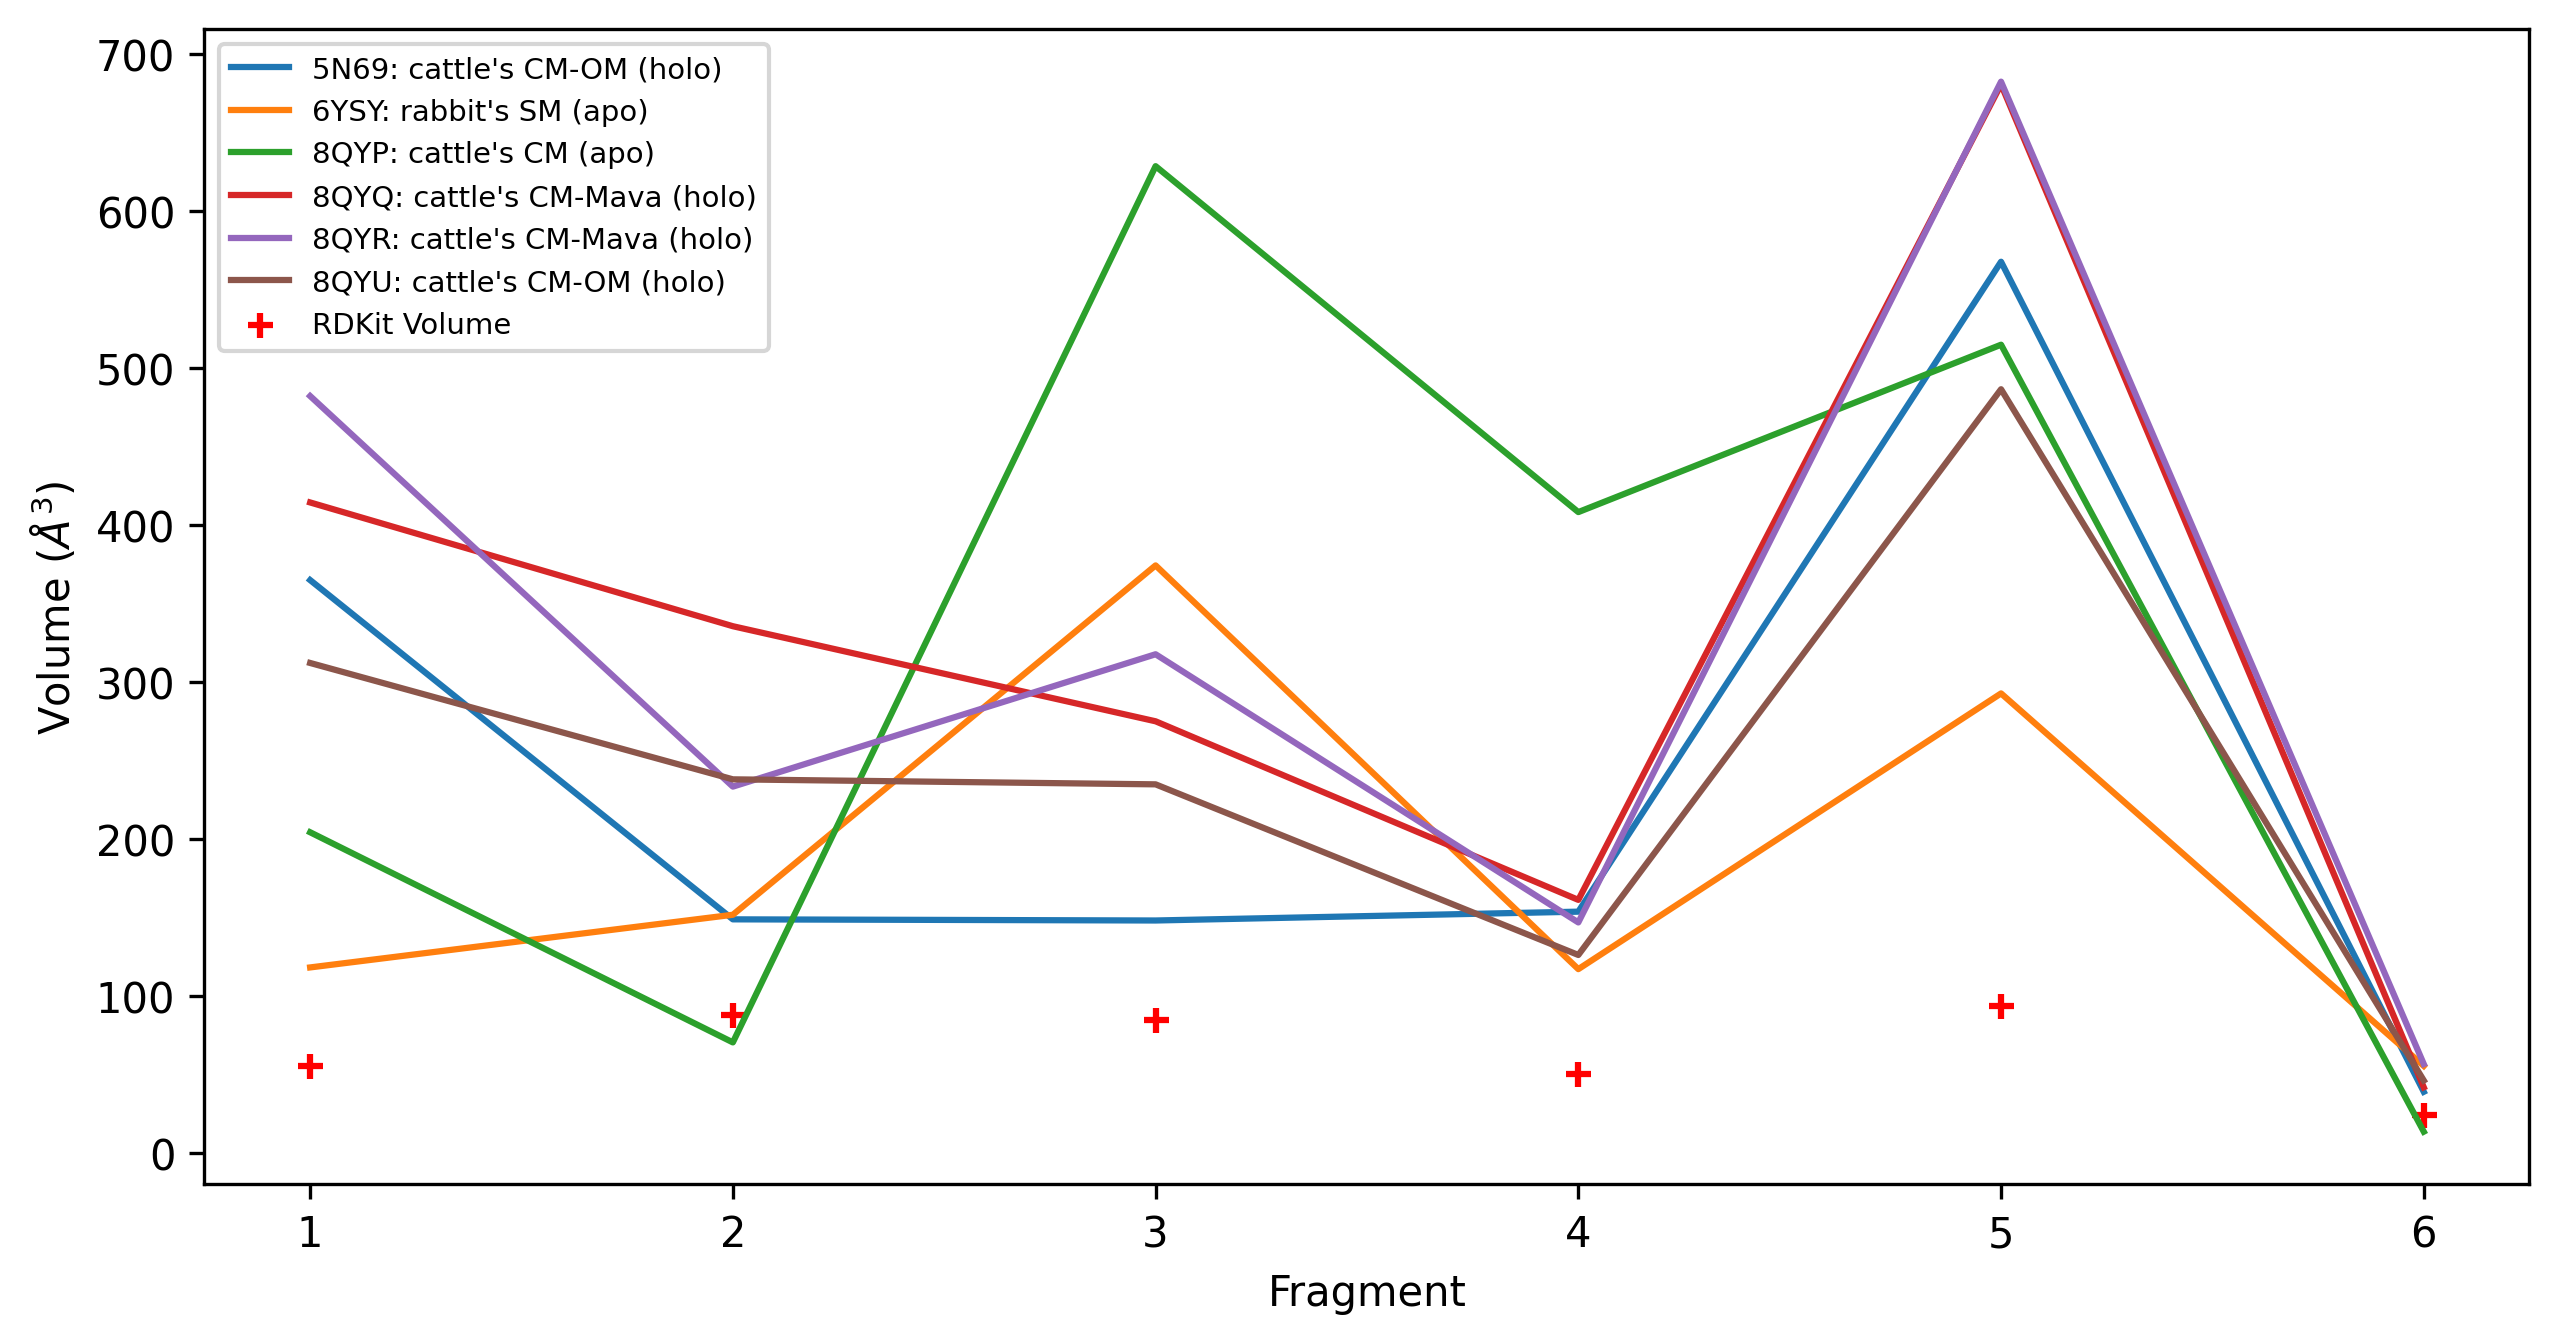

In [18]:
# plot for the HoloSpace vs Actual Volume
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
df_plot = hd_analyser.holospace_frag_volumes.T
df_plot.index = [i.split("_")[-1] for i in df_plot.index]
ax.plot(df_plot)
ax.scatter(range(0, 6), hd_analyser.fragment_vol, color="red", marker="+")
ax.set_xlabel("Fragment")
ax.set_ylabel(r"Volume ($\AA^3$)")
ax.legend(
    [
        annotation_dict[each.split("_")[0]]
        for each in hd_analyser.descriptors_df["filename"]
    ]
    + ["RDKit Volume"],
    fontsize=7,
)
fig.show()

The plot reveals that the HoloSpace in almost all structures is sufficient to accommodate the fragments, except for 8QYP at fragments 2 and 6.

## Conclusion  

You have now completed the tutorial and learned to:  

* Fetch PDBs from RCSB and prepare those structures for FragBEST-Myo  
* Recap how to operate your data using `TrajectoryHandler`  
* Generate holo descriptors with `HoloDescriptor`  
* Analyze and compare holo descriptors from different PDBs using `HoloDescriptorAnalyser`  

Next, proceed to **Tutorial 3** to learn how to analyze a real case of detecting holo-like conformations from an apo trajectory using parallel processors.